In [1]:
import numpy as np
import os
os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
from target import Target
from retrieval import Retrieval
from parameters import Parameters

brown_dwarf = 'test' # options: 2M0355 or 2M1425
chem = 'equchem' # options: freechem or equchem
PT_type = 'PTgrad' # options: PTknot or PTgrad
Nlive=70 # number of live points
tol=5.0 # evidence tolerance
output=f'{chem}_{PT_type}_N{Nlive}_ev{tol}' # output folder name

brown_dwarf = Target(brown_dwarf)

cloud_mode='gray' # options: None, gray, or MgSiO3
GP=True # options: True/False

constant_params={} # add if needed
free_params = {'rv': ([2,20],r'$v_{\rm rad}$'),
               'vsini': ([0,40],r'$v$ sin$i$'),
               'log_g':([3,5],r'log $g$'),
               'epsilon_limb': [(0.2,1), r'$\epsilon_\mathrm{limb}$']} # limb-darkening coefficient (0-1)

if PT_type=='PTknot':
    pt_params={'T0' : ([1000,4000], r'$T_0$'), # bottom of the atmosphere (hotter)
            'T1' : ([0,4000], r'$T_1$'),
            'T2' : ([0,4000], r'$T_2$'),
            'T3' : ([0,4000], r'$T_3$'),
            'T4' : ([0,4000], r'$T_4$'),} # top of atmosphere (cooler)
    free_params.update(pt_params)

if PT_type=='PTgrad':
    pt_params={'dlnT_dlnP_0': ([0.,0.4], r'$\nabla T_0$'), # gradient at T0 
            'dlnT_dlnP_1': ([0.,0.4], r'$\nabla T_1$'), 
            'dlnT_dlnP_2': ([0.,0.4], r'$\nabla T_2$'), 
            'dlnT_dlnP_3': ([0.,0.4], r'$\nabla T_3$'), 
            'dlnT_dlnP_4': ([0.,0.4], r'$\nabla T_4$'), 
            'T0': ([1000,4000], r'$T_0$')} # at bottom of atmosphere
    free_params.update(pt_params)

# if equilibrium chemistry, define [Fe/H], C/O, and isotopologue ratios
if chem=='equchem':
    chemistry={'C/O':([0,1], r'C/O'), 
            'Fe/H': ([-1.5,1.5], r'[Fe/H]'), 
            'C13_12_ratio': ([1e-10,1e-1], r'$\mathrm{^{13}C/^{12}C}$'), 
            'O18_16_ratio': ([1e-10,1e-1], r'$\mathrm{^{18}O/^{16}O}$'), 
            'O17_16_ratio': ([1e-10,1e-1], r'$\mathrm{^{17}O/^{12}O}$')}
    
# if free chemistry, define VMRs
if chem=='freechem': 
    chemistry={'log_H2O':([-12,-1],r'log H$_2$O'),
            'log_12CO':([-12,-1],r'log $^{12}$CO'),
            'log_13CO':([-12,-1],r'log $^{13}$CO'),
            'log_C18O':([-12,-1],r'log C$^{18}$O'),
            'log_C17O':([-12,-1],r'log C$^{17}$O'),
            'log_CH4':([-12,-1],r'log CH$_4$'),
            'log_NH3':([-12,-1],r'log NH$_3$'),
            'log_HCN':([-12,-1],r'log HCN'),
            'log_HF':([-12,-1],r'log HF'),
            'log_H2(18)O':([-12,-1],r'log H$_2^{18}$O'),
            'log_H2S':([-12,-1],r'log H$_2$S'),
            #'log_OH':([-12,-1],r'log OH'),
            #'log_CO2':([-12,-1],r'log CO$_2$')
            }
    
if cloud_mode=='gray':
    cloud_props={'log_opa_base_gray': ([-10,3], r'log $\kappa_{\mathrm{cl},0}$'),  
                'log_P_base_gray': ([-6,3], r'log $P_{\mathrm{cl},0}$'), # pressure of gray cloud deck
                'fsed_gray': ([0,20], r'$f_\mathrm{sed}$')} # sedimentation parameter for particles
    free_params.update(cloud_props)

if cloud_mode=='MgSiO3':
    cloud_props={'fsed': ([0,20], r'$f_\mathrm{sed}$'), # sedimentation parameter for particles
                'sigma_lnorm': ([0.8,1.5], r'$\sigma_{l,norm}$'), # width of the log-normal particle distribution
                'log_Kzz':([5,15],r'log $K_{zz}$')} # eddy diffusion parameter (atmospheric mixing)
    free_params.update(cloud_props)
    
if GP==True: # add uncertainty scaling
    GP_params={'log_a': ([-1,1], r'$\log\ a$'), # one is enough, will be multipled with order/det error
               'log_l': ([-3,0], r'$\log\ l$')}
    free_params.update(GP_params)

free_params.update(chemistry)
parameters = Parameters(free_params, constant_params)
cube = np.random.rand(parameters.n_params)
parameters(cube)
params=parameters.params

retrieval=Retrieval(target=brown_dwarf,parameters=parameters,
                    output_name=output,chemistry=chem,
                    cloud_mode=cloud_mode,GP=GP,PT_type=PT_type)

only_params=['rv','vsini','log_g','T0','log_H2O','log_12CO',
                'log_13CO','log_HF','log_H2(18)O','log_H2S']

retrieval.evaluate(only_params=only_params,split_corner=False)

  analysing data from /home/natalie/Desktop/files/uni/PhD/SupJup/codes/retrieval_base/atm_retrieval/atm_retrieval/test/equchem_PTgrad_N70_ev5.0/pmn_.txt


ValueError: 'log_H2O' is not in list

In [ ]:
import matplotlib.pyplot as plt

def VMR_plot(retrieval_object,fs=10,**kwargs):
    fig,ax=plt.subplots(1,1,figsize=(5,5),dpi=200)

    pressure=retrieval_object.final_object.pressure

    if retrieval_object.chemistry=='equchem':
        mass_fractions=retrieval_object.final_object.mass_fractions

        for species in ['H2','He','H2O','CO','CH4','HCN','NH3']:
            ax.plot(mass_fractions[species], pressure, label = species)

    ax.set(xlabel='VMR', ylabel='Pressure [bar]',yscale='log',xscale='log',
        ylim=(np.max(pressure),np.min(pressure)),xlim=(1e-10,1e-1))
    
    #ax.legend(handles=lines,fontsize=fs)
    ax.tick_params(labelsize=fs)
    ax.set_xlabel('Temperature [K]', fontsize=fs)
    ax.set_ylabel('Pressure [bar]', fontsize=fs)

(array([1., 0., 0., 2., 2., 0., 1., 0., 3., 2.]),
 array([0.64308492, 0.6465756 , 0.65006628, 0.65355695, 0.65704763,
        0.66053831, 0.66402899, 0.66751967, 0.67101034, 0.67450102,
        0.6779917 ]),
 <BarContainer object of 10 artists>)

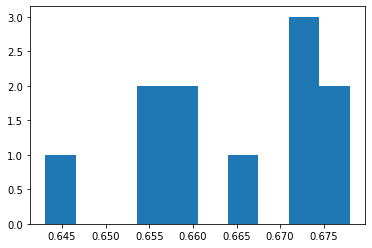

In [17]:
import matplotlib.pyplot as plt

retrieval.calc_errors=True
posterior=np.load('/home/natalie/Desktop/atm_retrieval/2M0355/freechem_PTgrad_N400_ev0.3/final_posterior.npy')
retrieval.posterior=posterior # shape (n_samples, n_params)

CO_distribution=np.full(posterior.shape[0],fill_value=np.nan)
CH_distribution=np.full(posterior.shape[0],fill_value=np.nan)
temperature_distribution=[] # for each of the n_atm_layers
x=0
for j,sample in enumerate(posterior):
    for i,key in enumerate(retrieval.parameters.param_keys):
        retrieval.parameters.params[key]=sample[i]
    retrieval.PMN_lnL()
    CO_distribution[j]=retrieval.model_object.CO
    CH_distribution[j]=retrieval.model_object.FeH
    temperature_distribution.append(retrieval.model_object.temperature)
    x+=1
    if x>10:
        break
#self.CO_CH_dist=np.vstack([CO_distribution,CH_distribution]).T
#self.temp_dist=temperature_distribution
#retrieval.calc_errors=False # set back to False when finished
        
plt.hist(CO_distribution)

In [3]:
import figures as figs
retrieval.PMN_analyse()
retrieval.get_ratios()
#figs.plot_pt(retrieval)
figs.ratios_cornerplot(retrieval)

  analysing data from /home/natalie/Desktop/files/uni/PhD/SupJup/codes/retrieval_base/atm_retrieval/atm_retrieval/2M0355/freechem_PTgrad_N400_ev0.3/pmn_.txt


AttributeError: 'Retrieval' object has no attribute 'atmosphere_objects'

In [17]:
def get_quantiles(posterior,flat=False):
    if flat==False: # input entire posterior of all retrieved parameters
        quantiles = np.array([np.percentile(posterior[:,i], [16.0,50.0,84.0], axis=-1) for i in range(posterior.shape[1])])
        medians=quantiles[:,1] # median of all params
        plus_err=quantiles[:,2]-medians # +error
        minus_err=quantiles[:,0]-medians # -error
    else: # input only one posterior
        quantiles = np.array([np.percentile(posterior, [16.0,50.0,84.0])])
        medians=quantiles[:,1] # median
        plus_err=quantiles[:,2]-medians # +error
        minus_err=quantiles[:,0]-medians # -error
    return medians,minus_err,plus_err

medians,minus_err,plus_err=get_quantiles(np.array(retrieval.temp_dist))
medians.shape

(50,)

In [9]:
temp_dist[0].shape

(50,)

In [16]:
temp_dist=np.array(retrieval.temp_dist)
#sm3,sm2,sm1,m,sp1,sp2,sp3 = np.array([np.percentile(temp_dist[:,i], [0.2,2.3,15.9,50.0,84.1,97.7,99.8], axis=-1) for i in range(temp_dist.shape[1])])
quantiles = np.array([np.percentile(temp_dist[:,i], [0.2,2.3,15.9,50.0,84.1,97.7,99.8], axis=-1) for i in range(temp_dist.shape[1])])
quantiles.shape

(50, 7)

In [15]:
np.array(retrieval.temp_dist)[:,0].shape

(21,)

In [2]:
retrieval2=Retrieval(target=Target('2M1425'),parameters=parameters,
                    output_name=output,chemistry=chem,
                    cloud_mode=cloud_mode,GP=GP,PT_type=PT_type)
retrieval2.evaluate()
figs.ratios_cornerplot(retrieval,retrieval_object2=retrieval2)

/home/natalie/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


  analysing data from /home/natalie/Desktop/files/uni/PhD/SupJup/codes/retrieval_base/atm_retrieval/atm_retrieval/2M1425/freechem_PTgrad_N400_ev0.3/pmn_.txt


NameError: name 'figs' is not defined

In [3]:
import figures as figs
figs.ratios_cornerplot(retrieval,retrieval_object2=retrieval2)

In [22]:
posterior=np.load('/home/natalie/Desktop/atm_retrieval/2M0355/freechem_PTgrad_N400_ev0.3/final_posterior.npy')
n_samples,n_params=posterior.shape[0],posterior.shape[1]
for sample in range(n_samples):
    print(posterior[sample])

[ 1.32406060e+01  3.05849481e+00  4.67482477e+00  8.06898510e-01
  3.15526643e-01  2.36897513e-01  3.71232663e-02  4.42568873e-02
  1.20624507e-01  2.25276200e+03 -2.35511678e+00 -1.22840439e+00
  1.00123916e+01  2.91421391e-01 -1.74024758e+00 -3.02606073e+00
 -2.74385020e+00 -4.78918846e+00 -8.67757543e+00 -1.05608171e+01
 -8.28190331e+00 -8.17893893e+00 -8.79158109e+00 -7.20381398e+00
 -5.55818340e+00 -4.74941607e+00]
[ 1.32443379e+01  2.96470169e+00  4.70940192e+00  6.69403020e-01
  3.52433604e-01  1.94154035e-01  3.42005876e-02  4.50401215e-02
  1.64183229e-01  2.43045898e+03 -3.50236962e+00 -7.10739198e-01
  4.22276460e+00  2.92349579e-01 -1.74221527e+00 -3.00450875e+00
 -2.69703267e+00 -4.59115943e+00 -9.86171563e+00 -8.87005643e+00
 -7.31088816e+00 -9.59237831e+00 -7.78101360e+00 -7.09371212e+00
 -1.09146749e+01 -4.15179188e+00]
[ 1.32676246e+01  3.09910522e+00  4.61667743e+00  6.44944907e-01
  1.99492474e-01  2.04137410e-01  3.83552341e-02  4.66083061e-02
  1.81095079e-01  2.51

0.9649446444209924
0.00028840315031266115


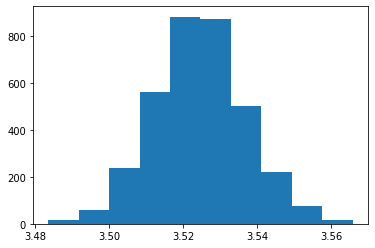

In [19]:
import matplotlib.pyplot as plt
import numpy as np

#https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting#11886564
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def get_quantiles(posterior):
    quantiles = np.array([np.percentile(posterior, [16.0,50.0,84.0])])
    medians=quantiles[:,1][0] # median of all params
    plus_err=quantiles[:,2][0]-medians # +error
    minus_err=quantiles[:,0][0]-medians # -error
    return medians,minus_err,plus_err

posterior=np.load('/home/natalie/Desktop/atm_retrieval/2M0355/freechem_PTgrad_N400_ev0.3/final_posterior.npy')

#ratios_posterior={}
for m1,m2 in [[['12CO','13CO'],['H2O']]]:#, # for metallicity, assumption Fe/H~C/H 
              #[['12CO','13CO'],['H2O','12CO','13CO']]]:#, # for C/O, carbon : oxygen containing species
              #['12CO','13CO'],['12CO','C17O'],['12CO','C18O'],['H2O','H2(18)O']]: # isotope ratios
    labels=['Fe/H','C/O'] # must be in order Fe/H, C/O, isotope ratios...
    if isinstance(m1,list) and isinstance(m2,list):
        x=0
        numerator=[]
        for i in range(len(m1)):
            numerator.append(posterior[:,list(retrieval.parameters.params).index(f'log_{m1[i]}')])
        numerator=10**np.array(numerator) # was in log10 before
        numerator=np.sum(numerator,axis=0) # sum values in numerator
        denominator=[]
        for i in range(len(m2)):
            denominator.append(posterior[:,list(retrieval.parameters.params).index(f'log_{m2[i]}')])
        denominator=10**np.array(denominator) # was in log10 before
        denominator=2*np.sum(denominator,axis=0) # sum values in numerator
        ratio=numerator/denominator
        print(np.median(ratio))
        log_ratio=np.log10(numerator)-np.log10(denominator)

        if labels[x]=='Fe/H':
            log_CH_solar = 8.46 - 12 # Asplund et al. (2021)
            print(10**log_CH_solar)
            log_ratio -= log_CH_solar

        median,minus_err,plus_err=get_quantiles(log_ratio)
        #self.final_params[f'log_{labels[i]}']=median
        #self.final_params[f'log_{labels[i]}_err']=(minus_err,plus_err)
        #self.ratios_posterior[f'log_{labels[i]}']=log_ratio

        filtered = log_ratio[~is_outlier(log_ratio)]
        plt.hist(filtered)
        x+=1
    else:
        p1=posterior[:,list(retrieval.parameters.params).index(f'log_{m1}')]
        p2=posterior[:,list(retrieval.parameters.params).index(f'log_{m2}')]
        log_ratio=p1-p2
        median,minus_err,plus_err=get_quantiles(log_ratio)
        #self.final_params[f'log_{m1}/{m2}']=median
        #self.final_params[f'log_{m1}/{m2}_err']=(minus_err,plus_err)
        #self.ratios_posterior[f'log_{m1}/{m2}']=log_ratio



In [1]:
import matplotlib.pyplot as plt
import numpy as np

#https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting#11886564
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def get_quantiles(posterior):
    quantiles = np.array([np.percentile(posterior, [16.0,50.0,84.0])])
    medians=quantiles[:,1][0] # median of all params
    plus_err=quantiles[:,2][0]-medians # +error
    minus_err=quantiles[:,0][0]-medians # -error
    return medians,minus_err,plus_err

posterior=np.load('/home/natalie/Desktop/atm_retrieval/2M0355/freechem_PTgrad_N400_ev0.3/final_posterior.npy')

for m1,m2 in [['12CO','13CO'],['12CO','C17O'],['12CO','C18O'],['H2O','H2(18)O']]: # isotope ratios    
    p1=posterior[:,list(retrieval.parameters.params).index(f'log_{m1}')]
    p2=posterior[:,list(retrieval.parameters.params).index(f'log_{m2}')]
    log_ratio=p1-p2
    median,minus_err,plus_err=get_quantiles(log_ratio)
    #self.final_params[f'log_{m1}/{m2}']=median
    #self.final_params[f'log_{m1}/{m2}_err']=(minus_err,plus_err)
    #self.ratios_posterior[f'log_{m1}/{m2}']=log_ratio
    
    print(median,minus_err,plus_err)
    if 'ratios_posterior' in locals():
        ratios_posterior=np.vstack([ratios_posterior,log_ratio])
    else:
        ratios_posterior=log_ratio
    #filtered = log_ratio[~is_outlier(log_ratio)]
    #plt.hist(filtered)

print(ratios_posterior.T.shape)

NameError: name 'retrieval' is not defined

In [4]:
retrieval.final_object.posterior.shape

AttributeError: 'Retrieval' object has no attribute 'final_object'

2.0260942411068816
[2.02609424] [-0.86922683] [3.13238866]


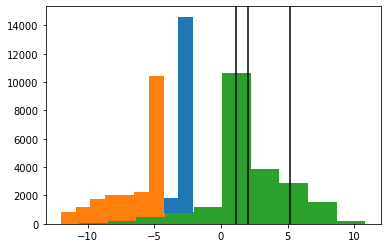

In [16]:
import matplotlib.pyplot as plt
posterior=np.load('/home/natalie/Desktop/atm_retrieval/2M0355/freechem_PTgrad_N400_ev0.3/live_posterior.npy')
list(retrieval.parameters.params).index('log_H2O')
p12CO=posterior[:,list(retrieval.parameters.params).index('log_12CO')]
p13CO=posterior[:,list(retrieval.parameters.params).index('log_13CO')]
r12CO13CO=p12CO-p13CO
plt.hist(p12CO)
plt.hist(p13CO)
plt.hist(r12CO13CO)
print(np.median(r12CO13CO))

def get_quantiles(posterior):
    quantiles = np.array([np.percentile(posterior, [16.0,50.0,84.0])])
    medians=quantiles[:,1] # median of all params
    plus_err=quantiles[:,2]-medians # +error
    minus_err=quantiles[:,0]-medians # -error
    return medians,minus_err,plus_err
medians,minus_err,plus_err=get_quantiles(r12CO13CO)
print(medians,minus_err,plus_err)
plt.axvline(x=medians,c='k')
plt.axvline(x=medians+minus_err,c='k')
plt.axvline(x=medians+plus_err,c='k')

In [11]:
retrieval.posterior.shape

(3452, 26)

In [ ]:
retrieval.parameter.sparams.shape

In [1]:
import numpy as np
import os
os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
from target import Target
from retrieval import Retrieval
from parameters import Parameters
BD=Target('2M0355')
BD.load_spectrum()

(array([[[1921.3069573 , 1921.31348054, 1921.32015565, ...,
          1934.56868023, 1934.57498295, 1934.58144918],
         [1935.53936778, 1935.54567721, 1935.55208614, ...,
          1948.19704201, 1948.20308875, 1948.2091354 ],
         [1949.08767248, 1949.09368943, 1949.09970629, ...,
          1961.11604389, 1961.12177904, 1961.12751406]],
 
        [[1989.97568923, 1989.98242383, 1989.98936671, ...,
          2003.68793429, 2003.69444923, 2003.7009641 ],
         [2004.79842365, 2004.80468758, 2004.81105947, ...,
          2018.01330855, 2018.01990302, 2018.02653574],
         [2018.72267776, 2018.72892052, 2018.73516319, ...,
          2031.17295052, 2031.17888254, 2031.1848496 ]],
 
        [[2063.70729026, 2063.7143441 , 2063.72146797, ...,
          2077.93238749, 2077.93933565, 2077.94612273],
         [2078.96257173, 2078.96944067, 2078.97623222, ...,
          2092.54295013, 2092.54943152, 2092.55596603],
         [2093.50754088, 2093.51398833, 2093.52043568, ...,
      

In [2]:
retrieval2=Retrieval(target=Target('2M1425'),parameters=parameters,
                    output_name=output,chemistry=chem,
                    cloud_mode=cloud_mode,GP=GP,PT_type=PT_type)
retrieval2.evaluate()
#import figures as figs
#figs.compare_two(retrieval,retrieval2)

/home/natalie/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


  analysing data from /home/natalie/Desktop/files/uni/PhD/SupJup/codes/retrieval_base/atm_retrieval/atm_retrieval/2M1425/freechem_PTgrad_N400_ev0.4/pmn_.txt


In [8]:
import pickle
import pathlib
path=pathlib.Path('/home/natalie/Desktop/atm_retrieval/2M1425/freechem_PTgrad_N300_ev0.5/final_params_dict.pickle')
with open(path,'rb') as file:
    final_params=pickle.load(file)
# print S/N + sigma for latex table
for molecule in ['13CO','HF','H2S','H2(18)O']:
    SNR=np.round(final_params[f'SNR_{molecule}'],decimals=2)
    sigma=np.round(final_params[f'sigma_{molecule}'],decimals=2)
    print(SNR,'\&',sigma,'\\\\')

5.11 \& 4.11 \\
4.69 \& 3.82 \\
-0.08 \& 3.49 \\
1.11 \& -1.79 \\


In [26]:
def error_propagation_division(f,A,Ame,Ape,B,Bme,Bpe):
    fme=np.sqrt(f**2*((Ame/A)**2+(Bme/B)**2)) # minus error of f when f=A*B
    fpe=np.sqrt(f**2*((Ape/A)**2+(Bpe/B)**2)) # plus error of f when f=A*B
    return fme,fpe

VMR_12CO=(final_params['log_12CO'])
VMR_12CO_me=(final_params['log_12CO_err'][0]) # minus error
VMR_12CO_pe=(final_params['log_12CO_err'][1]) # plus error
VMR_13CO=(final_params['log_13CO'])
VMR_13CO_me=(final_params['log_13CO_err'][0]) # minus error
VMR_13CO_pe=(final_params['log_13CO_err'][1]) # plus error
C1213=VMR_12CO-VMR_13CO
error_propagation_division(C1213,VMR_12CO,VMR_12CO_me,VMR_12CO_pe,VMR_13CO,VMR_13CO_me,VMR_13CO_pe)
#print(10**C1213,10**fme,10**fpe)

(0.05974278284146701, 0.05072152823398621)

In [30]:
dict1={'key':1}
dict2={'key2':2,'key3':3}
dict1.update(dict2)
dict1

{'key': 1, 'key2': 2, 'key3': 3}

In [ ]:
path=pathlib.Path('/home/natalie/Desktop/atm_retrieval/test/freechem_PTgrad_N100_ev5.0/evidence_retrievals/final_wo13CO_params_dict.pickle')
with open(path,'rb') as file:
    final_params=pickle.load(file)
final_params#['sigma_13CO']

# Fix plots

In [ ]:
import matplotlib.pyplot as plt
import cloud_cond as cloud_cond
import numpy as np
from labellines import labelLine, labelLines
from matplotlib.lines import Line2D

fig,ax=plt.subplots(1,1,figsize=(5,5),dpi=100)

pressure = np.logspace(-6,2,50)


#ax.plot(temperature,pressure,color='deepskyblue',lw=2)
#ax.scatter(retrieval.final_object.t_samp,10**retrieval.final_object.p_samp,color='deepskyblue')
#xmin=np.min(retrieval.final_object.t_samp)-100
#xmax=np.max(retrieval.final_object.t_samp)+100

ax.set(xlabel='Temperature [K]', ylabel='Pressure [bar]', yscale='log', 
    ylim=(np.nanmax(pressure),np.nanmin(pressure)))
    #xlim=(xmin,xmax))

# T=1400K, logg=4.65 -> 10**(4.65)/100 =  446 m/s²
file=np.loadtxt('t1400g562nc_m0.0.dat')
pres=file[:,1] # bar
temp=file[:,2] # K
ax.plot(temp,pres,linestyle='dashdot',c='blueviolet',linewidth=2)

# https://github.com/cphyc/matplotlib-label-lines
labelLines(ax.get_lines(),align=False,fontsize=9,drop_label=True)
lines = [Line2D([0], [0], marker='o', color='deepskyblue', markerfacecolor='deepskyblue' ,linewidth=2, linestyle='-'),
        Line2D([0], [0], color='blueviolet', linewidth=2, linestyle='dashdot'),
        Line2D([0], [0], color='gold', linewidth=1.5, linestyle='--')]
labels = ['This retrieval', 'Sonora Bobcat \n$T=1400\,$K, log$\,g=4.75$','Contribution']
ax.legend(lines,labels,fontsize=9)

callback_label='live_'
params_pm=np.load(f'{output_dir}/{callback_label}params_pm.npy')
indices=[]
for key in ['T1','T2','T3','T4']:
    idx=list(params).index(key)
    indices.append(idx)
T_pm=np.array([params_pm[:,i] for i in indices]).T # mean, lower, upper
lowers=T_pm[1][::-1] # reverse order so that T4,T3,T2,T1
uppers=T_pm[2][::-1]
from scipy.interpolate import CubicSpline
p_samp= np.linspace(np.log10(np.nanmin(pressure)),np.log10(np.nanmax(pressure)),len(uppers))
#sort = np.argsort(p_samp)
lower = CubicSpline(p_samp,lowers)(np.log10(pressure))
upper = CubicSpline(p_samp,uppers)(np.log10(pressure))
#ax.plot(self.final_object.temperature, self.final_object.pressure,color='deepskyblue',lw=2
ax.scatter(lowers,10**p_samp)
ax.scatter(uppers,10**p_samp)
ax.fill_betweenx(pressure,lower,upper,color='deepskyblue',alpha=0.2)
#ax.plot(T_pm[0],p_samp,color='deepskyblue',lw=2)

In [ ]:
import corner

output_dir='/home/natalie/Desktop/PhD/SupJup/codes/retrieval_base/atm_retrieval/atm_retrieval/2M0355_test7'
posterior=np.load(f'{output_dir}/live_posterior.npy')
abunds=['log_H2O','log_12CO']
indices=[]
for key in abunds:
    idx=list(params).index(key)
    indices.append(idx)
new_posterior=np.array([posterior[:,i] for i in indices]).T

fig = corner.corner(new_posterior, 
                    labels=abunds, 
                    title_kwargs={'fontsize': 12},
                    color='slateblue',
                    linewidths=0.5,
                    fill_contours=True,
                    quantiles=[0.16,0.84],
                    show_titles=True
                    )

quantiles = np.array([np.percentile(new_posterior[:,i], [16.0,50.0,84.0], axis=-1) for i in range(new_posterior.shape[1])])
means=quantiles[:,1] # mean of all params
uppers=quantiles[:,2]-means # +error
lowers=quantiles[:,0]-means # -error
corner.overplot_lines(fig, means,color='r',lw=1,linestyle='solid') # plot mean, second column
#corner.overplot_lines(fig, means+uppers,color='c',lw=1,linestyle='solid')
#corner.overplot_lines(fig, means+lowers,color='m',lw=1,linestyle='solid')


# Check species missing in fit, lines not included in model

# Make plots for presentation

In [ ]:
import getpass
import os
import numpy as np
import matplotlib.pyplot as plt
os.environ['OMP_NUM_THREADS'] = '1' # to avoid using too many CPUs

if getpass.getuser() == "grasser": # when runnig from LEM
    os.environ['pRT_input_data_path'] ="/net/lem/data2/pRT_input_data"
    os.environ['OMP_NUM_THREADS'] = '1' # important for MPI
    from mpi4py import MPI 
    comm = MPI.COMM_WORLD # important for MPI
    rank = comm.Get_rank() # important for MPI
    from atm_retrieval.target import Target
    from atm_retrieval.likelihood import Retrieval
    from atm_retrieval.parameters import Parameters
    import matplotlib
    matplotlib.use('Agg') # disable interactive plotting
elif getpass.getuser() == "natalie": # when testing from my laptop
    os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
    from target import Target
    from likelihood import Retrieval
    from parameters import Parameters
    from pRT_model import pRT_spectrum


M0355 = Target('2M0355')
data_wave,data_flux,data_err=M0355.load_spectrum()

constant_params = {'vsini': 2, # rotational velocity
                'rv': 11.92,
                'log_Kzz': 7.5, # eddy diffusion parameter (atmospheric mixing)
                'fsed': 2, # sedimentation parameter for particles
                'P_base_gray': 1, # pressure of gray cloud deck
                'fsed_gray': 2,
                'opa_base_gray': 0.8, # opacity of gray cloud deck
                'sigma_lnorm': 1.05, # width of the log-normal particle distribution of MgSiO3
                'log_MgSiO3' : 0, # scaling wrt chem equilibrium, 0 = equilibrium abundance 
                'log_H2O': -2.9,#-2.9,
                'log_12CO': -2.67,#-2.66,
                'log_13CO':-4.9,
                'log_C18O':-12, #-8.3,
                'log_C17O':-12,  #-8.7,
                'log_CH4':-12, #-8.6,
                'log_NH3':-12, #-8.9,
                'log_HCN':-12, #-8,
                'T1' : 2500, # bottom of the atmosphere (hotter)
                'T2' : 1500,
                'T3' : 1270,
                'T4' : 313, # top of atmosphere (cooler)
                'log_g':4.95,
                } 

free_params = {}
parameters = Parameters(free_params,constant_params)
params=parameters.params


output='2M0355_test4'
retrieval=Retrieval(target=M0355,parameters=parameters,output_name=output)
atmosphere_objects=retrieval.atmosphere_objects

species=retrieval.get_species(param_dict=parameters.params)
model_flux=pRT_spectrum(parameters=params,data_wave=data_wave,target=M0355,
                        atmosphere_objects=atmosphere_objects,species=species,
                        free_chem=True).make_spectrum()


In [ ]:
params_H2O=params.copy()
params_H2O['log_12CO']=-12
params_H2O['log_13CO']=-12
H2O_flux=pRT_spectrum(parameters=params_H2O,data_wave=data_wave,target=M0355,
                        atmosphere_objects=atmosphere_objects,species=species,
                        free_chem=True).make_spectrum()

params_CO=params.copy()
params_CO['log_H2O']=-12
params_CO['log_13CO']=-12
CO_flux=pRT_spectrum(parameters=params_CO,data_wave=data_wave,target=M0355,
                        atmosphere_objects=atmosphere_objects,species=species,
                        free_chem=True).make_spectrum()

In [ ]:
fig,ax=plt.subplots(2,1,figsize=(7,3),dpi=200,sharex=True)
order=5
det=0
for i in range(2):
    ax[i].plot(data_wave[order,det],data_flux[order,det],lw=1,alpha=0.8,c='k',label='data')
    ax[i].set_xlim(np.nanmin(data_wave[order,det]),np.nanmax(data_wave[order,det]))
    ax[i].yaxis.set_visible(False) # remove ylabels because anyway unitless

ax[0].plot(data_wave[order,det],model_flux[order,det],lw=1,alpha=0.8,c='c',label='model')
ax[1].plot(data_wave[order,det],H2O_flux[order,det],lw=1,alpha=0.8,c='tab:blue',label='H$_2$O')
ax[1].plot(data_wave[order,det],CO_flux[order,det],lw=1,alpha=0.8,c='tab:orange',label='CO')

ax[0].legend(fontsize=8)
ax[1].legend(fontsize=8)
ax[1].set_xlabel('Wavelength [nm]')
fig.tight_layout(h_pad=-0.1)
fig.savefig('/home/natalie/Desktop/PhD/SupJup/plots/spectrum.jpg')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(7,2),dpi=200,sharex=True)
order=5
det=0
#ax.plot(data_wave[order,det],data_flux[order,det],lw=1,alpha=0.8,c='k',label='data')
ax.set_xlim(np.nanmin(data_wave[order,det]),np.nanmax(data_wave[order,det]))
ax.plot(data_wave[order,det],model_flux[order,det],lw=1,alpha=0.8,c='c',label='model')
#ax.legend(fontsize=8)
ax.yaxis.set_visible(False) # remove ylabels because anyway unitless
ax.set_xlabel('Wavelength [nm]')
fig.tight_layout()
fig.savefig('/home/natalie/Desktop/PhD/SupJup/plots/model.jpg')

In [ ]:
params_bad=params.copy()
params_bad['log_H2O']=-3.5
params_bad['log_CO']=-2
params_bad['vsini']=7
params_bad['T1']=1700
bad_flux=pRT_spectrum(parameters=params_bad,data_wave=data_wave,target=M0355,
                        atmosphere_objects=atmosphere_objects,species=species,
                        free_chem=True).make_spectrum()
fig,ax=plt.subplots(1,1,figsize=(7,2),dpi=200,sharex=True)
order=5
det=0
#ax.plot(data_wave[order,det],data_flux[order,det],lw=1,alpha=0.8,c='k',label='data')
ax.set_xlim(np.nanmin(data_wave[order,det]),np.nanmax(data_wave[order,det]))
ax.plot(data_wave[order,det],bad_flux[order,det],lw=1,alpha=1,c='c',label='model')
#ax.legend(fontsize=8)
ax.yaxis.set_visible(False) # remove ylabels because anyway unitless
ax.set_xlabel('Wavelength [nm]')
fig.tight_layout()
fig.savefig('/home/natalie/Desktop/PhD/SupJup/plots/bad_model1.jpg')